# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 8*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1*100 # mJy
mask_theta = 2*u.arcmin
Nsim = 1000
apply_radial_model = True
clean_ksz = False

# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

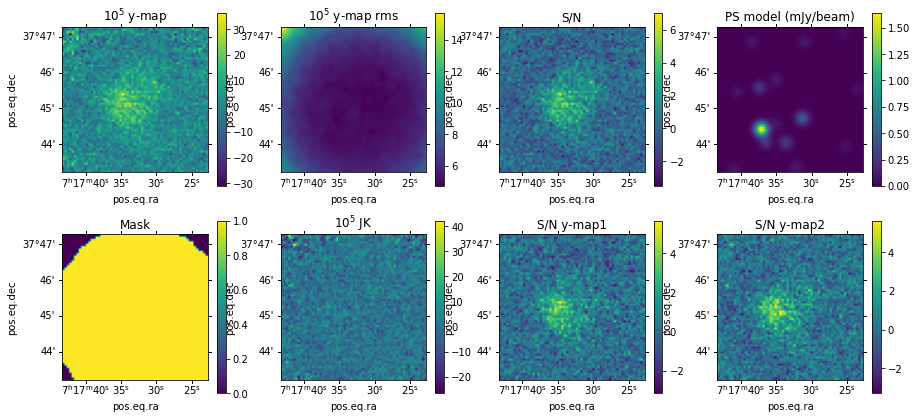

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True,
                                                                                                     clean_ksz=clean_ksz)

# Define the model, data and inference

In [5]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [6]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

In [7]:
#========== Inference radial
cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit1/')
cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit2/')
cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit3/')
cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit4/')
cl_Rinfer5 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit5/')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radial Inference                        
------------------------------------------------------------
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radi

# Fit the smooth model to the data

In [8]:
#========== Curvefit the profile case 1
RA  = cl_Rinfer1.model.coord.ra
Dec = cl_Rinfer1.model.coord.dec
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer1.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 23.047159121724135 -0.795273041769466 +0.80833069417125
   best-fit = 22.982468628234866 -0.7305825482801964 +0.8730211876605196
   M500 = 23.047159121724135_{-0.795273041769466}^{0.80833069417125}
param 1 (RA): 
   median   = 109.38865436616679 -0.0003062826801283336 +0.0001964503463653955
   best-fit = 109.38850152024287 -0.00015343675620727026 +0.0003492962702864588
   RA = 109.38865436616679_{-0.0003062826801283336}^{0.0001964503463653955}
param 2 (Dec): 
   median   = 37.752457588868744 -0.0003245272080931727 +0.00033411326405996533
   best-fit = 37.752785180188475 -0.0006521185278245412 +6.521944328596874e-06
   Dec = 37.752457588868744_{-0.0003245272080931727}^{0.00033411326405996533}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.8848781595402999 -0.02746957410012585 +0.027598823360365454
   best-fit = 0.8885210226582605 -0.03111243721808643 +0.023955960242404872
   min_to_maj_axis_ratio = 0.8848781595402999_{-0.02746957410012585}^{0.0275988233

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [9]:
#========== Curvefit the profile case 2
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'ZL':{'guess':[0,1e-5],'unit':None},
}
plist, popt, pcov = cl_Rinfer2.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 15.891026920054458 -0.485069888890008 +0.5024774017308253
   best-fit = 15.899025237832072 -0.49306820666762263 +0.4944790839532107
   M500 = 15.891026920054458_{-0.485069888890008}^{0.5024774017308253}
param 1 (ZL): 
   median   = 1.8367140455776738e-05 -1.0013556681693168e-06 +1.0172069167984576e-06
   best-fit = 1.863275746147417e-05 -1.2669726738667478e-06 +7.515899111010265e-07
   ZL = 1.8367140455776738e-05_{-1.0013556681693168e-06}^{1.0172069167984576e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [10]:
#========== Curvefit the profile case 3
RA  = cl_Rinfer3.model.coord.ra
Dec = cl_Rinfer3.model.coord.dec

fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer3.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 20.830817019811906 -0.5192943278947375 +0.5242939403843501
   best-fit = 20.824382971722542 -0.5128602798053734 +0.5307279884737142
   M500 = 20.830817019811906_{-0.5192943278947375}^{0.5242939403843501}
param 1 (RA): 
   median   = 109.38865568348922 -0.00030277717222304545 +0.00019107823764841214
   best-fit = 109.38875229937732 -0.0003993930603201079 +9.446234955134969e-05
   RA = 109.38865568348922_{-0.00030277717222304545}^{0.00019107823764841214}
param 2 (Dec): 
   median   = 37.75235523872999 -0.00032407442246551454 +0.00033028791276734637
   best-fit = 37.75269231174751 -0.0006611474399846884 +-6.785104751827475e-06
   Dec = 37.75235523872999_{-0.00032407442246551454}^{0.00033028791276734637}
param 3 (ZL): 
   median   = 1.5401360832461245e-05 -1.0104303950688417e-06 +1.0184159246973961e-06
   best-fit = 1.5762960049096254e-05 -1.372029611703851e-06 +6.568167080623868e-07
   ZL = 1.5401360832461245e-05_{-1.0104303950688417e-06}^{1.0184159246973961

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [11]:
#========== Curvefit the profile
RA  = cl_Rinfer4.model.coord.ra
Dec = cl_Rinfer4.model.coord.dec

fitpar_prof = {
'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer4.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.11268298966715976 -0.007864429307917142 +0.007841577398874033
   best-fit = 0.10917513831119995 -0.004356577951957333 +0.011349428754833843
   P_0 = 0.11268298966715976_{-0.007864429307917142}^{0.007841577398874033}
param 1 (r_p): 
   median   = 734.3284700384152 -38.35184592728149 +38.346863736826094
   best-fit = 734.2265874959214 -38.24996338478775 +38.448746279319835
   r_p = 734.3284700384152_{-38.35184592728149}^{38.346863736826094}
param 2 (RA): 
   median   = 109.38872803089978 -0.00021890315437644858 +0.00014260541811950134
   best-fit = 109.38882123271283 -0.0003121049674206233 +4.9403605075326595e-05
   RA = 109.38872803089978_{-0.00021890315437644858}^{0.00014260541811950134}
param 3 (Dec): 
   median   = 37.75241875134108 -0.000252956834621898 +0.0002458948349755019
   best-fit = 37.75269980522912 -0.0005340107226601276 +-3.515905306272771e-05
   Dec = 37.75241875134108_{-0.000252956834621898}^{0.0002458948349755019}
param 4 (min_to_maj_axis

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [12]:
#========== Curvefit the profile
RA  = cl_Rinfer5.model.coord.ra
Dec = cl_Rinfer5.model.coord.dec

fitpar_prof = {
'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
'b': {'guess':[5, 0.5], 'unit': None, 'limit':[2, 8]},
'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[0, 2]},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer5.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.10922667185765694 -0.07364573570270555 +0.07645150535051956
   best-fit = 0.11385035946171476 -0.07826942330676337 +0.07182781774646174
   P_0 = 0.10922667185765694_{-0.07364573570270555}^{0.07645150535051956}
param 1 (r_p): 
   median   = 486.83722399947317 -258.5525165667322 +261.4026984907754
   best-fit = 842.6998079741765 -614.4151005414355 +-94.4598854839279
   r_p = 486.83722399947317_{-258.5525165667322}^{261.4026984907754}
param 2 (a): 
   median   = 1.6574119910334983 -0.23874812132118484 +0.21587154507984452
   best-fit = 1.2874326158117717 --0.1312312539005418 +0.5858509203015712
   a = 1.6574119910334983_{-0.23874812132118484}^{0.21587154507984452}
param 3 (b): 
   median   = 5.094611593172271 -2.00621083949143 +1.9445390906672353
   best-fit = 5.7866377611692155 -2.6982370074883746 +1.2525129226702907
   b = 5.094611593172271_{-2.00621083949143}^{1.9445390906672353}
param 4 (c): 
   median   = 0.1661840920866902 -0.11609548051067722 +0.1236

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


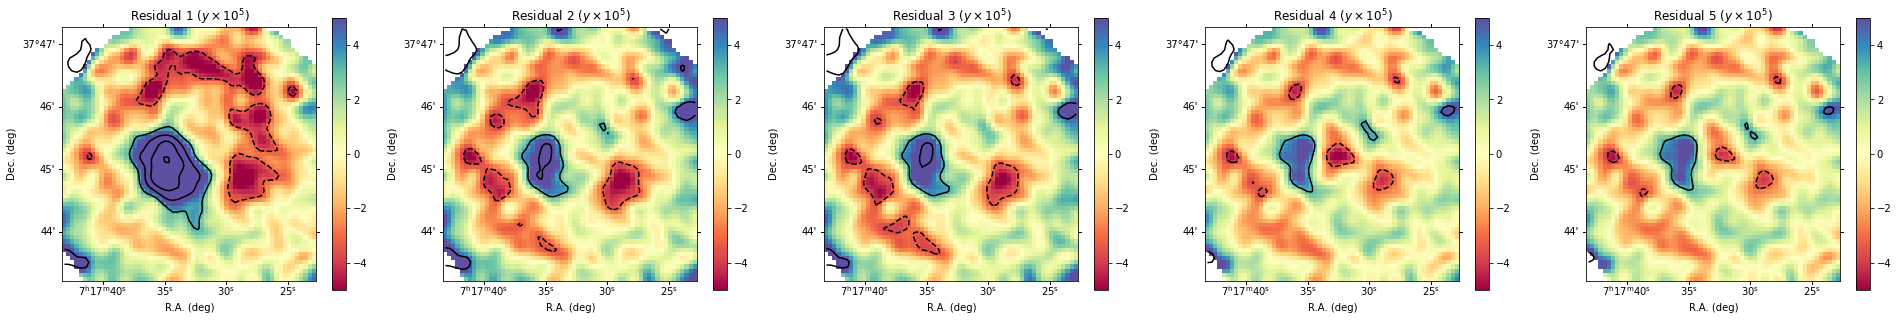

In [13]:
#===== Show the images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(33, 5))
model_sph1 = cl_Rinfer1.get_radial_model()
model_sph2 = cl_Rinfer2.get_radial_model()
model_sph3 = cl_Rinfer3.get_radial_model()
model_sph4 = cl_Rinfer4.get_radial_model()
model_sph5 = cl_Rinfer5.get_radial_model()
    
rms = cl_data.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
    
rng = [-5,5]

msk = copy.deepcopy(cl_data.mask)
msk[cl_data.mask == 0] = np.nan
    
#----- Residual 1
ax = plt.subplot(1, 5, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 1 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(1, 5, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph3, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph3, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 2 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 3 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph4, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph4, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 4 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 5, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph5, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph5, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 5 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

plt.savefig(outdir+'/RadialFit_residuals.pdf')